In [1]:
] instantiate

In [2]:
using Arrow
using Clustering
using DataFrames
using Distances
using FreqTables
using Plots
using Statistics

In [3]:
df = DataFrame(Arrow.Table("sales.arrow"))
mat = Matrix(df)

52×811 Matrix{Float64}:
  0.369588    1.27724     -0.579404  …   0.571772  -0.594121  -0.438798
  0.640272    0.854207     0.790096     -0.571772  -0.594121   0.987295
  0.0989037  -0.414901    -0.237029     -0.571772  -0.594121  -0.438798
 -0.442464   -0.837937     0.105346     -0.571772   1.22319   -0.438798
  0.910956    1.27724      0.447721      0.571772  -0.594121  -0.438798
  0.640272   -1.26097     -0.237029  …   0.571772  -0.594121  -0.438798
  1.18164     0.854207    -0.579404      1.71532   -0.594121  -0.438798
  3.07643    -0.414901     1.47485       0.571772  -0.594121  -0.438798
 -0.983832   -0.414901     1.13247       0.571772   1.22319   -0.438798
  1.18164    -0.414901    -0.921779     -0.571772  -0.594121  -0.438798
  0.369588   -0.837937     1.81722   …  -0.571772  -0.594121  -0.438798
  1.18164    -0.837937     0.105346      0.571772  -0.594121  -0.438798
  1.72301     0.854207    -1.60653      -0.571772  -0.594121  -0.438798
  ⋮                                  ⋱  

In [4]:
r = pairwise(SqEuclidean(), mat, dims=2)

811×811 Matrix{Float64}:
   0.0      92.4649   99.5619  100.616   …  106.024   130.323   109.839
  92.4649    0.0      98.3234   83.6628     114.094   107.648    76.2906
  99.5619   98.3234    0.0      68.1371     124.708   100.468    90.3569
 100.616    83.6628   68.1371    0.0        106.491   125.017    56.6453
  90.1702  110.762   100.439   102.426       94.9381  104.072   123.475
 116.16     85.1388  106.798    92.9689  …   64.0414   75.4033   93.5627
 101.583    96.2544  101.267    94.2715     109.237   107.573   123.105
 107.022    81.8551  122.745   115.459      102.0      95.5615  107.649
  82.2256   90.6944  106.477   117.051      106.643   117.949   115.006
  85.2477  108.437    94.3263  127.657      106.288    81.005   118.455
  91.4367  106.137    93.5677   93.1621  …   86.9315  117.775   100.339
  94.9118   91.0407   95.4248   99.273       93.0782   80.0053   80.4323
 109.203   101.32     89.2011   73.4217     104.422   118.022   105.484
   ⋮                              

In [5]:
eps = 20.0:0.5:70
minpts = 1:6

1:6

In [6]:
sil_avg = Vector{Float64}[]
cl_num = Vector{Int64}[]
cl_size = Vector{Float64}[]

for m in minpts
    sil = Float64[]
    num = Int64[]
    size = Float64[]
    for ε in eps
        clusters = dbscan(r, ε, m)
        ids = clusters.assignments
        if maximum(ids) <= 1
            push!(sil, NaN)
        else
            non_noise = ids .!= 0
            push!(sil, mean(silhouettes(ids[non_noise], r[non_noise, non_noise])))
        end
        push!(num, maximum(ids))
        push!(size, mean(clusters.counts))
    end
    push!(sil_avg, sil)
    push!(cl_num, num)
    push!(cl_size, size)
end

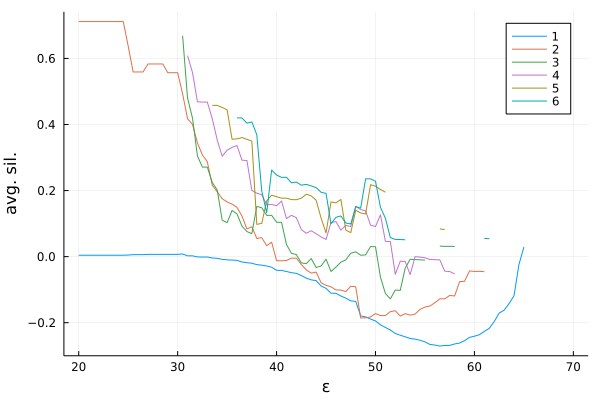

In [7]:
plot(eps, sil_avg, xlabel="ε", ylabel="avg. sil.", labels=["1" "2" "3" "4" "5" "6"])

In [8]:
plot(eps, cl_num[2:end], xlabel="ε", ylabel="cl. num.", labels=["2" "3" "4" "5" "6"])

In [9]:
plot(eps, cl_size[2:end], xlabel="ε", ylabel="cl. size", labels=["2" "3" "4" "5" "6"])

In [10]:
plot(eps, cl_num[6])

In [11]:
plot(eps, sil_avg[end])

In [12]:
best_mpts = 6
best_ε = 49.5
best_clustering = dbscan(r, best_ε, best_mpts)

DbscanResult([17, 100], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0  …  0, 0, 0, 2, 2, 0, 2, 2, 0, 0], [90, 249])

In [13]:
freqtable(best_clustering.assignments)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
0     │ 472
1     │  90
2     │ 249

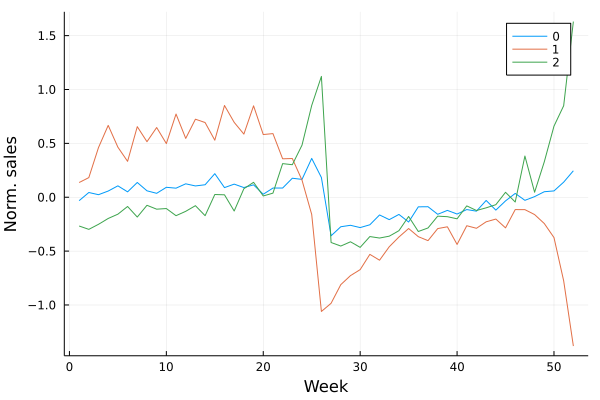

In [14]:
plot(mean(mat[:, best_clustering.assignments .== 0], dims=2), xlabel="Week", ylabel="Norm. sales", label="0")
plot!(mean(mat[:, best_clustering.assignments .== 1], dims=2), label="1")
plot!(mean(mat[:, best_clustering.assignments .== 2], dims=2), label="2")

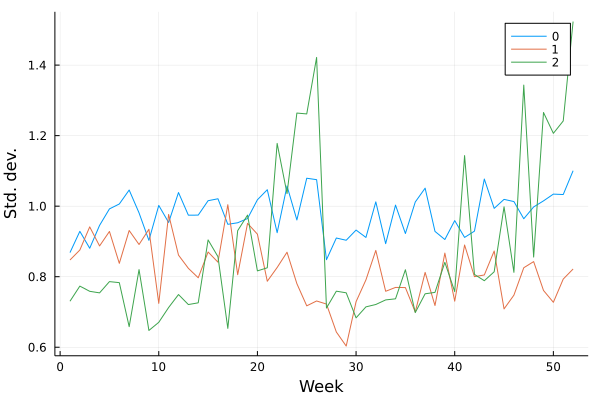

In [15]:
plot(std(mat[:, best_clustering.assignments .== 0], dims=2), xlabel="Week", ylabel="Std. dev.", label="0")
plot!(std(mat[:, best_clustering.assignments .== 1], dims=2), label="1")
plot!(std(mat[:, best_clustering.assignments .== 2], dims=2), label="2")

In [16]:
m2_clusters = parse.(Int64, readlines("cluster_assignments.txt"));

In [17]:
freqtable(best_clustering.assignments, m2_clusters)

3×4 Named Matrix{Int64}
Dim1 ╲ Dim2 │   1    2    3    4
────────────┼───────────────────
0           │ 137  170   97   68
1           │  89    0    1    0
2           │   1   42  109   97

In [18]:
open("cluster_assignments_dbscan.txt", "w") do f
  foreach(asgn -> println(f, asgn), best_clustering.assignments)
end

DbScan cluster 1: constant sales until mid-year, then sharp drop, then recovery, another drop in the end of the year.
DbScan cluster 2: grows, peak in the mid-year, then sharp drop, then growth again, another peak in the end of the year.
DbScan outliers: interesting, also affected by mid-year drop.
